In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading Cleaned Dataset

In [3]:
train_data = pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/cleaned_dataset.csv',sep=',')
test_data = pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/cleaned_validation_dataset.csv',sep=',')

# Preparing data for the model

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Y = train_data.target
X = train_data.text

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# SVC classifier

## Fitting 

In [5]:
# using Label Powerset
from sklearn.svm import SVC
# initialize label powerset multi-label classifier
classifier = SVC()
# train
classifier.fit(X_train_vec, y_train)
# predict
predictions = classifier.predict(X_test_vec)

from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.7268408551068882

## Creating submission file

In [6]:
sub_data = vectorizer.transform(test_data.text)
predictions = classifier.predict(sub_data)

In [7]:
sample_sub=pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/sample_submission.csv')
submission=pd.DataFrame()
submission['id']=sample_sub.id.values.tolist()
submission['target']=np.round(predictions).astype(int)
submission.to_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Submission/sub_1.csv',index=False)

the f1 score of this submission is 

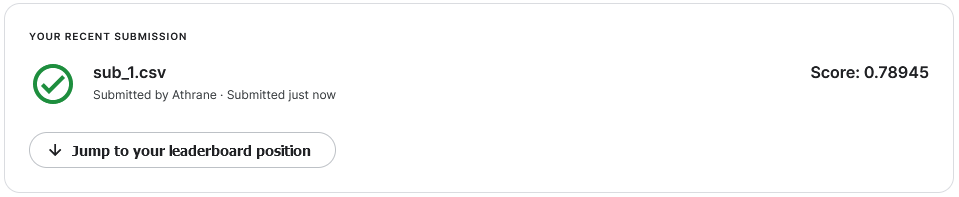

let's see if we can improve this score with a deep learning model

# DL model with Embedding layer

In [8]:
my_tokenizer = tf.keras.preprocessing.text.Tokenizer()
my_tokenizer.fit_on_texts(train_data.text)
encoded_text = my_tokenizer.texts_to_sequences(train_data.text)
vocab_size = len(my_tokenizer.word_index)+1
padded_text = tf.keras.preprocessing.sequence.pad_sequences(encoded_text, padding = 'post')

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Building the model

In [10]:
# word embedding model
model = Sequential()
model.add(Embedding(vocab_size, 16, input_length=len(padded_text[1])))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
# compilaton
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc',f1,])
# summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 16)            257904    
                                                                 
 flatten (Flatten)           (None, 432)               0         
                                                                 
 dense (Dense)               (None, 1)                 433       
                                                                 
Total params: 258,337
Trainable params: 258,337
Non-trainable params: 0
_________________________________________________________________
None


## Fitting the model

In [11]:
model.fit(padded_text, train_data.target, epochs = 20,validation_split = 0.33, verbose = 1)
loss, accuracy,f1_score = model.evaluate(padded_text, train_data.target)
print('f1: %f' % (f1_score))
print('accuracy: %f' % (accuracy*100))

Epoch 1/20
160/160 [==============================] - 3s 6ms/step - loss: 0.6671 - acc: 0.5890 - f1: 0.0995 - val_loss: 0.6604 - val_acc: 0.5778 - val_f1: 0.0761
Epoch 2/20
160/160 [==============================] - 1s 5ms/step - loss: 0.5484 - acc: 0.7731 - f1: 0.6219 - val_loss: 0.5734 - val_acc: 0.7294 - val_f1: 0.4872
Epoch 3/20
160/160 [==============================] - 1s 4ms/step - loss: 0.3722 - acc: 0.8841 - f1: 0.8424 - val_loss: 0.5208 - val_acc: 0.7477 - val_f1: 0.5331
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.2534 - acc: 0.9292 - f1: 0.9092 - val_loss: 0.5082 - val_acc: 0.7577 - val_f1: 0.5894
Epoch 5/20
160/160 [==============================] - 1s 4ms/step - loss: 0.1791 - acc: 0.9516 - f1: 0.9405 - val_loss: 0.5052 - val_acc: 0.7569 - val_f1: 0.5774
Epoch 6/20
160/160 [==============================] - 1s 4ms/step - loss: 0.1297 - acc: 0.9676 - f1: 0.9595 - val_loss: 0.5105 - val_acc: 0.7485 - val_f1: 0.5787
Epoch 7/20
160/160 [========

## Creating submission file

In [12]:
val_encoded_text = my_tokenizer.texts_to_sequences(test_data.text)
#val_vocab_size = len(my_tokenizer.word_index)+1
val_padded_text = tf.keras.preprocessing.sequence.pad_sequences(val_encoded_text, padding = 'post',maxlen = len(padded_text[1]))

In [13]:
predictions = model.predict(val_padded_text)

In [14]:
sample_sub=pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/sample_submission.csv')
submission=pd.DataFrame()
submission['id']=sample_sub.id.values.tolist()
submission['target']=np.round(predictions).astype(int)
submission.to_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Submission/sub_2.csv',index=False)

the f1 score obtained is 
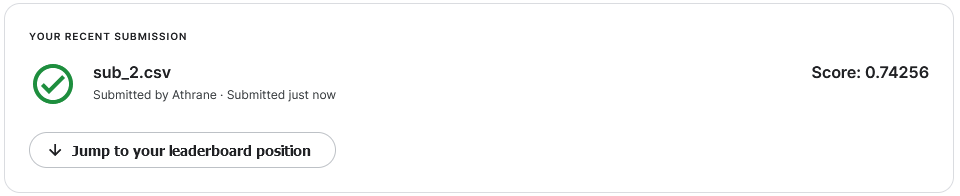
let's try to improve it with a pretrained embedding model

This score is worse than the one with SVC, let's try to a pretrained embedding model and see.

# DL GloVe Embedding

## Loading the embedding matrix

In [15]:
embeddings_index = dict()
f = open('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Pretrained_word_embedding/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [16]:
embedding_matrix = np.zeros((vocab_size, 100))
for element in train_data.text:
  for word, i in my_tokenizer.word_index.items():
	  embedding_vector = embeddings_index.get(word)
	  if embedding_vector is not None:
		  embedding_matrix[i] = embedding_vector
GloVe_Embedding = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=len(padded_text[1]), trainable=False)

## Building the model

In [17]:
# model with GloVe Embedding
model_2 = Sequential()
model_2.add(GloVe_Embedding)
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))
# compilaton
model_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc',f1,])
# summary
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 100)           1611900   
                                                                 
 flatten_1 (Flatten)         (None, 2700)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2701      
                                                                 
Total params: 1,614,601
Trainable params: 2,701
Non-trainable params: 1,611,900
_________________________________________________________________
None


## Fitting the model

In [18]:
model_2.fit(padded_text, train_data.target, epochs = 20,validation_split = 0.2,verbose = 1)
loss, accuracy,f1_score = model_2.evaluate(padded_text, train_data.target)
print('f1: %f' % (f1_score))
print('accuracy: %f' % (accuracy*100))

Epoch 1/20
191/191 [==============================] - 1s 4ms/step - loss: 0.5765 - acc: 0.7144 - f1: 0.6160 - val_loss: 0.5184 - val_acc: 0.7728 - val_f1: 0.6375
Epoch 2/20
191/191 [==============================] - 1s 4ms/step - loss: 0.4917 - acc: 0.7810 - f1: 0.7174 - val_loss: 0.5073 - val_acc: 0.7774 - val_f1: 0.6229
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: 0.4659 - acc: 0.7908 - f1: 0.7257 - val_loss: 0.4996 - val_acc: 0.7774 - val_f1: 0.6226
Epoch 4/20
191/191 [==============================] - 1s 3ms/step - loss: 0.4499 - acc: 0.7989 - f1: 0.7435 - val_loss: 0.4957 - val_acc: 0.7787 - val_f1: 0.6405
Epoch 5/20
191/191 [==============================] - 1s 3ms/step - loss: 0.4381 - acc: 0.8056 - f1: 0.7522 - val_loss: 0.4959 - val_acc: 0.7722 - val_f1: 0.6309
Epoch 6/20
191/191 [==============================] - 1s 3ms/step - loss: 0.4278 - acc: 0.8105 - f1: 0.7541 - val_loss: 0.4999 - val_acc: 0.7663 - val_f1: 0.6238
Epoch 7/20
191/191 [========

## Creating submission file

In [19]:
predictions = model_2.predict(val_padded_text)

In [20]:
sample_sub=pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/sample_submission.csv')
submission=pd.DataFrame()
submission['id']=sample_sub.id.values.tolist()
submission['target']=np.round(predictions).astype(int)
submission.to_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Submission/sub_3.csv',index=False)

the f1 score is 

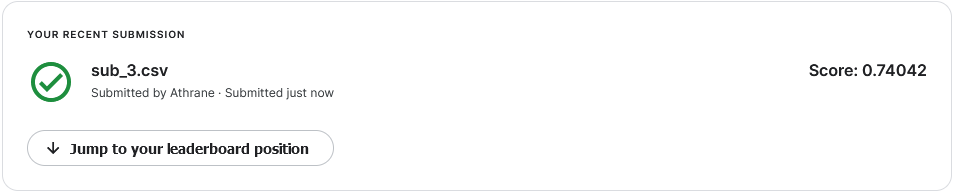

This score is also worse than the one with SVC, let's add an LSTM

# DL model with LSTM layer

## Building model

In [21]:
from tensorflow.keras.layers import LSTM
# Define the Keras model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 16, input_length=len(padded_text[1])))
model_3.add(LSTM(10))
model_3.add(Dense(1, activation='sigmoid'))
# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1,])
# Give a summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 27, 16)            257904    
                                                                 
 lstm (LSTM)                 (None, 10)                1080      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 258,995
Trainable params: 258,995
Non-trainable params: 0
_________________________________________________________________


## Fitting

In [22]:
model_3.fit(padded_text, train_data.target, epochs = 20,validation_split = 0.33,verbose = 1)
loss, accuracy,f1_score = model_3.evaluate(padded_text, train_data.target)
print('f1: %f' % (f1_score))
print('accuracy: %f' % (accuracy*100))

Epoch 1/20
160/160 [==============================] - 5s 10ms/step - loss: 0.6437 - acc: 0.6233 - f1: 0.1654 - val_loss: 0.5489 - val_acc: 0.7497 - val_f1: 0.5803
Epoch 2/20
160/160 [==============================] - 1s 7ms/step - loss: 0.3837 - acc: 0.8535 - f1: 0.8143 - val_loss: 0.5174 - val_acc: 0.7513 - val_f1: 0.5871
Epoch 3/20
160/160 [==============================] - 1s 8ms/step - loss: 0.2303 - acc: 0.9269 - f1: 0.9093 - val_loss: 0.6010 - val_acc: 0.7278 - val_f1: 0.6078
Epoch 4/20
160/160 [==============================] - 1s 7ms/step - loss: 0.1514 - acc: 0.9565 - f1: 0.9455 - val_loss: 0.6437 - val_acc: 0.7290 - val_f1: 0.6014
Epoch 5/20
160/160 [==============================] - 1s 8ms/step - loss: 0.1120 - acc: 0.9671 - f1: 0.9585 - val_loss: 0.6920 - val_acc: 0.7358 - val_f1: 0.5809
Epoch 6/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0890 - acc: 0.9753 - f1: 0.9698 - val_loss: 0.8545 - val_acc: 0.7051 - val_f1: 0.5762
Epoch 7/20
160/160 [=======

## Creating submission file

In [23]:
predictions = model_3.predict(val_padded_text)

In [24]:
sample_sub=pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/sample_submission.csv')
submission=pd.DataFrame()
submission['id']=sample_sub.id.values.tolist()
submission['target']=np.round(predictions).astype(int)
submission.to_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Submission/sub_4.csv',index=False)

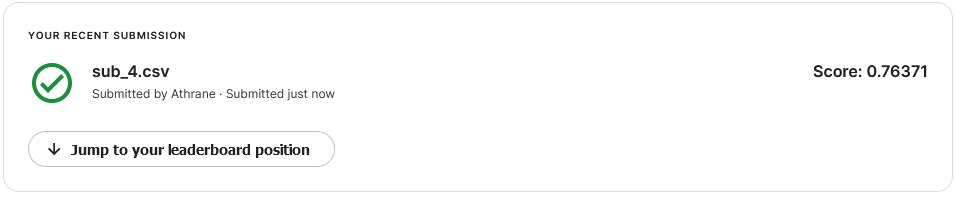

Better than previous DL model but not as good as the SVC prediction

# DL model with Fasttext embedding

## installing Fasttext

In [25]:
pip install fasttext

## Loading the Fasttext_model with Bidirectional LSTM

In [27]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

## Creating Embedding Matrix

In [29]:
embedding_matrix = np.zeros((vocab_size, 300))
for element in train_data.text:
  for word, i in my_tokenizer.word_index.items():
	  embedding_vector = ft.get_word_vector(word)
	  if embedding_vector is not None:
		  embedding_matrix[i] = embedding_vector
Fasttext_Embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=len(padded_text[1]), trainable=False)

## Building the model

In [46]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
# Define the Keras model
model_4 = Sequential()
model_4.add(Fasttext_Embedding)
model_4.add(Bidirectional(LSTM(10), merge_mode='sum'))
model_4.add(Dense(1, activation='sigmoid'))
# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1,])
# Give a summary
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 300)           4835700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 10)               24880     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,860,591
Trainable params: 24,891
Non-trainable params: 4,835,700
_________________________________________________________________


## Fitting

In [51]:
model_4.fit(padded_text, train_data.target, epochs = 20,validation_split = 0.2,verbose = 1)
loss, accuracy,f1_score = model_4.evaluate(padded_text, train_data.target)
print('f1: %f' % (f1_score))
print('accuracy: %f' % (accuracy*100))

Epoch 1/20
191/191 [==============================] - 2s 13ms/step - loss: 0.2634 - acc: 0.9110 - f1: 0.8866 - val_loss: 0.7639 - val_acc: 0.7446 - val_f1: 0.6185
Epoch 2/20
191/191 [==============================] - 2s 9ms/step - loss: 0.2303 - acc: 0.9181 - f1: 0.8959 - val_loss: 0.7516 - val_acc: 0.7518 - val_f1: 0.6342
Epoch 3/20
191/191 [==============================] - 2s 9ms/step - loss: 0.2118 - acc: 0.9261 - f1: 0.9051 - val_loss: 0.7482 - val_acc: 0.7584 - val_f1: 0.6299
Epoch 4/20
191/191 [==============================] - 2s 8ms/step - loss: 0.1984 - acc: 0.9317 - f1: 0.9143 - val_loss: 0.7720 - val_acc: 0.7544 - val_f1: 0.6379
Epoch 5/20
191/191 [==============================] - 2s 8ms/step - loss: 0.1871 - acc: 0.9360 - f1: 0.9205 - val_loss: 0.7782 - val_acc: 0.7492 - val_f1: 0.6394
Epoch 6/20
191/191 [==============================] - 2s 8ms/step - loss: 0.1814 - acc: 0.9379 - f1: 0.9207 - val_loss: 0.7900 - val_acc: 0.7538 - val_f1: 0.6405
Epoch 7/20
191/191 [=======

## Creating submission file

In [44]:
predictions = model_4.predict(val_padded_text)

In [45]:
sample_sub=pd.read_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Data/sample_submission.csv')
submission=pd.DataFrame()
submission['id']=sample_sub.id.values.tolist()
submission['target']=np.round(predictions).astype(int)
submission.to_csv('/content/drive/My Drive/Parcours_IML/IML_Projet_8/Submission/sub_5.csv',index=False)

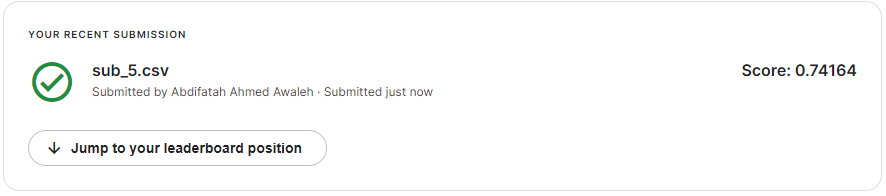

i haven't been able to improve the score thus the best submission remain the one with the SVC